In [ ]:
#@title Initial Setup

import os, sys
from IPython.utils import io

with io.capture_output() as cap:
  !apt install tree
  !pip install geopandas
  !pip install netCDF4
  # https://github.com/SciTools/cartopy/issues/1490
  !apt-get -qq install python-cartopy python3-cartopy
  !pip uninstall -y shapely
  !pip install --no-binary shapely shapely==1.7.0 --force
  !pip install --no-binary cartopy cartopy==0.18.0
  !pip install git+https://github.com/tkrajina/srtm.py

%cd /content/drive/My Drive/Posgrado/Geophysics/Colab/ML/test

with open('installs_SRTM.txt', 'w') as f:
    f.write(cap.stdout)
%ls -altrh

sys.path.append("/usr/local/lib/python3.6/site-packages")
from IPython.display import set_matplotlib_formats
from IPython.display import display, display_svg
from IPython.display import Markdown, Math, Latex
from IPython.display import Javascript, IFrame, HTML

from io import StringIO
import requests

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
set_matplotlib_formats('pdf', 'svg')
from matplotlib import style
#style.use('classic')
# import turbo_colormap_mpl
import graphviz 
from graphviz import Source

# https://github.com/tkrajina/srtm.py
import srtm
elevation_data = srtm.get_data()
get_elevation_vectorized = np.vectorize(
    elevation_data.get_elevation,
    otypes=[float]
    )

import fiona
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape
from shapely.geometry import mapping
from shapely.ops import unary_union
from netCDF4 import Dataset as netcdf_dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# https://github.com/SciTools/cartopy/issues/1120#issuecomment-424418760
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# Avoids scroll-in-the-scroll in the entire Notebook
# https://stackoverflow.com/a/66891328
def resize_colab_cell():
  display(Javascript(
      'google.colab.output.setIframeHeight(0, true, {maxHeight: 4000})'
      ))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

def dLatex(self):
  return display(Latex(self))

def dMarkdown(self):
  return display(Markdown(self))

<IPython.core.display.Javascript object>

/content/drive/My Drive/Posgrado/Geophysics/Colab/ML/test
total 110M
-rw------- 1 root root  9.6M Sep 18  2020 MGN2020_DPTO_POLITICO.rar
-rw------- 1 root root   54M Sep 18  2020 MGN2020_MPIO_POLITICO.rar
drwx------ 2 root root  4.0K Jan 17 22:25 MGN2020/
-rw------- 1 root root   14K Jan 17 23:35 turbo_colormap_mpl.py
drwx------ 2 root root  4.0K Jan 17 23:35 __pycache__/
-rw------- 1 root root  478K Jan 19 18:59 colomb97_elevations.csv
-rw------- 1 root root  234K Jan 19 19:02 installs_IA.txt
-rw------- 1 root root  363K Jan 19 19:21 LinearReg_diff_train.csv
-rw------- 1 root root   16K Jan 19 19:21 LinearReg_diff_train_hist.pdf
-rw------- 1 root root   18K Jan 19 19:21 SVR-rbf_diff_train_hist.pdf
-rw------- 1 root root  363K Jan 19 19:21 SVR-rbf_diff_train.csv
-rw------- 1 root root   18K Jan 19 19:21 SVR-poly_diff_train_hist.pdf
-rw------- 1 root root  362K Jan 19 19:21 SVR-poly_diff_train.csv
-rw------- 1 root root  363K Jan 19 19:21 SVR-linear_diff_train.csv
-rw------- 1 root root

In [ ]:
#@title `colomb97` Data

colomb97 = pd.read_csv(
    'colomb97.csv',
    index_col=0    
    )
colomb97_train = pd.read_csv(
    'colomb97_train.csv',
    index_col=0    
    )
colomb97_test = pd.read_csv(
    'colomb97_test.csv',
    index_col=0    
    )

dMarkdown('**Train Sorted:**')
display(colomb97_train.sort_index())

dMarkdown('**Test Sorted:**')
display(colomb97_test.sort_index())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Train Sorted:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
2,7.56000,-73.16500,975.00,4.46,-104.60,-93.72
6,7.69000,-73.09670,1290.00,38.49,-105.90,-93.75
8,7.74500,-73.05500,2050.00,136.63,-92.76,-75.37
9,7.69500,-73.28330,512.00,-17.91,-75.21,-70.53
11,7.79667,-73.34830,204.00,-65.13,-87.96,-82.56
...,...,...,...,...,...,...
9046,3.88333,-76.99333,60.58,-55.96,-62.74,-62.07
9047,3.88833,-77.01667,51.83,-58.04,-63.84,-63.33
9048,3.88333,-77.01500,39.15,-59.40,-63.78,-63.23


**Test Sorted:**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
1,7.57167,-73.19830,750.00,-17.42,-101.30,-92.48
3,7.65000,-73.22000,550.00,-31.69,-93.24,-86.08
4,7.65500,-73.17830,730.00,-16.26,-97.95,-88.07
5,7.66000,-73.12670,1000.00,-1.60,-113.50,-99.03
7,7.72833,-73.07670,1650.00,80.20,-104.40,-88.80
...,...,...,...,...,...,...
9028,3.84667,-76.81833,163.17,-5.39,-23.65,-22.27
9034,3.86500,-76.87500,181.85,-8.47,-28.82,-27.33
9036,3.86833,-76.89500,204.99,-11.82,-34.76,-33.35


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Name,geometry
0,my_rectangle,"POLYGON ((-75.25000 6.85000, -75.25000 5.75000..."


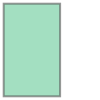

**`my_rectangle_data:`**

,latitude,longitude,sea_level_elev_m,Free_air_anom,Bouguer_anom_simp,Bouguer_anom_267
station_id,,,,,,
57,6.77667,-75.65670,2993.00,336.76,1.84,30.78
58,6.81333,-75.68500,2795.00,269.47,-43.30,-10.90
59,6.77500,-75.59330,2733.00,250.48,-55.35,-31.09
60,6.81000,-75.91830,1418.00,91.02,-67.66,-48.61
61,6.78333,-75.83170,1225.00,85.10,-51.98,-35.79
...,...,...,...,...,...,...
7388,6.41667,-75.38333,1319.68,38.26,-109.40,-76.38
7389,6.43333,-75.34333,1300.99,31.89,-113.70,-96.51
7390,6.44583,-75.34333,1242.39,25.96,-113.10,-96.95


CPU times: user 201 ms, sys: 3.6 ms, total: 205 ms
Wall time: 216 ms


In [ ]:
#@title Load `my_rectangle`
%%time
my_rectangle_gpd = gpd.read_file('MGN2020/my_rectangle.shp')
display(my_rectangle_gpd)
my_rectangle = my_rectangle_gpd['geometry'].values[0]
display(my_rectangle)

my_rectangle_mask = np.array([
        my_rectangle.contains(Point(*point)) for point in
          colomb97[['longitude','latitude']].to_numpy()
        ])
my_rectangle_data = colomb97[my_rectangle_mask]

dMarkdown('**`my_rectangle_data:`**')
display(my_rectangle_data)

In [ ]:
#@title Save `elevs_data.npy`, `my_rectangle_srtm.csv`
%%time

step    = .01
bounds  = np.reshape(my_rectangle.bounds,(2,2))
lon_min = bounds[0,0]
lat_min = bounds[0,1]
lon_max = bounds[1,0]
lat_max = bounds[1,1]
lons = np.arange(lon_min,lon_max+step,step)
lats = np.arange(lat_min,lat_max+step,step)
z    = get_elevation_vectorized(*np.meshgrid(lats,lons)).T

srtmdf = pd.DataFrame(
    [[lat,lon] for lat in lats for lon in lons],
    columns=['latitude','longitude']
    )
srtmdf = srtmdf.assign(
    SRTM = lambda x:get_elevation_vectorized(
        srtmdf.latitude,
        srtmdf.longitude
        )
    ).interpolate(method='nearest')

elevs = np.reshape(
    srtmdf['SRTM'].to_numpy(),
    np.shape(z)
    )


np.save('elevs_data.npy', 
        np.array([lons, lats, elevs],
                 dtype=object)
        )

srtmdf.to_csv('my_rectangle_srtm.csv')
my_rectangle_srtm = pd.read_csv(
    'my_rectangle_srtm.csv',
    index_col=[0]
    )

elevs_data = np.load(
    'elevs_data.npy',
    allow_pickle=True
    )
lons, lats, elevs = elevs_data
my_shape = np.shape(elevs)
dMarkdown('**`elevs_data:`**')
display(elevs_data)

print('\n')
srtmdf = pd.read_csv(
    'my_rectangle_srtm.csv',
    index_col=[0]
    )
dMarkdown('**`my_rectangle_srtm:`**')
display(srtmdf)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**`elevs_data:`**

array([array([-75.92, -75.91, -75.9 , -75.89, -75.88, -75.87, -75.86, -75.85,
       -75.84, -75.83, -75.82, -75.81, -75.8 , -75.79, -75.78, -75.77,
       -75.76, -75.75, -75.74, -75.73, -75.72, -75.71, -75.7 , -75.69,
       -75.68, -75.67, -75.66, -75.65, -75.64, -75.63, -75.62, -75.61,
       -75.6 , -75.59, -75.58, -75.57, -75.56, -75.55, -75.54, -75.53,
       -75.52, -75.51, -75.5 , -75.49, -75.48, -75.47, -75.46, -75.45,
       -75.44, -75.43, -75.42, -75.41, -75.4 , -75.39, -75.38, -75.37,
       -75.36, -75.35, -75.34, -75.33, -75.32, -75.31, -75.3 , -75.29,
       -75.28, -75.27, -75.26, -75.25, -75.24]),
       array([5.75, 5.76, 5.77, 5.78, 5.79, 5.8 , 5.81, 5.82, 5.83, 5.84, 5.85,
       5.86, 5.87, 5.88, 5.89, 5.9 , 5.91, 5.92, 5.93, 5.94, 5.95, 5.96,
       5.97, 5.98, 5.99, 6.  , 6.01, 6.02, 6.03, 6.04, 6.05, 6.06, 6.07,
       6.08, 6.09, 6.1 , 6.11, 6.12, 6.13, 6.14, 6.15, 6.16, 6.17, 6.18,
       6.19, 6.2 , 6.21, 6.22, 6.23, 6.24, 6.25, 6.26, 6.27, 6.28, 6.29,
    

**`my_rectangle_srtm:`**

,latitude,longitude,SRTM
0,5.75,-75.92,1088.0
1,5.75,-75.91,1152.0
2,5.75,-75.90,1158.0
3,5.75,-75.89,1092.0
4,5.75,-75.88,1479.0
...,...,...,...
7654,6.85,-75.28,1680.0
7655,6.85,-75.27,1887.0
7656,6.85,-75.26,2006.0
7657,6.85,-75.25,2039.0


CPU times: user 223 ms, sys: 16.6 ms, total: 239 ms
Wall time: 278 ms


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

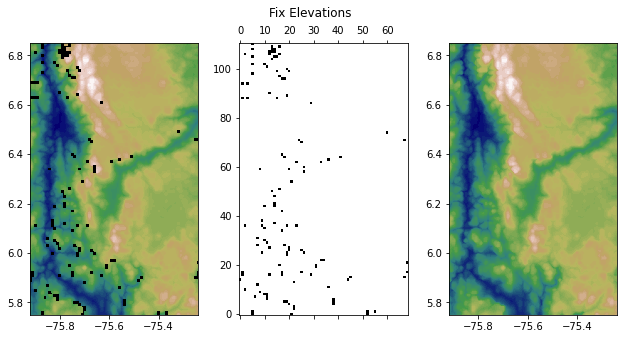

CPU times: user 2.08 s, sys: 36.8 ms, total: 2.12 s
Wall time: 2.14 s


In [ ]:
#@title Fix SRTM Elevations
%%time

set_matplotlib_formats('png')
fig, axs = plt.subplots(1,3,
                        figsize=(15,15/3),
                        sharey=False,
                        gridspec_kw={'wspace': -.5}
                        )
cf=axs[0].contourf(
    lons, lats, z,
    levels=50,
    cmap='gist_earth',
    corner_mask=False
    )
# Rasterize the contour collections
# https://stackoverflow.com/a/32911755
for c in cf.collections:
    c.set_edgecolor('face')
axs[0].set_facecolor('k')
axs[0].set_aspect(1)
axs[1].matshow(
    ~(elevs==z),
    cmap='binary',
    origin='lower'
    )
axs[1].set_aspect(1)

srtmdf = srtmdf.interpolate(method='nearest')
elevs = np.reshape(srtmdf['SRTM'].to_numpy(), my_shape)
cf=axs[2].contourf(
    lons, lats, elevs,
    levels=50,
    cmap='gist_earth',
    corner_mask=False
    )
# Rasterize the contour collections
# https://stackoverflow.com/a/32911755
for c in cf.collections:
    c.set_edgecolor('face')
axs[2].set_aspect(1)
plt.suptitle('Fix Elevations', y=.98)
plt.savefig(
    'Fix_Elevations.pdf',
    bbox_inches='tight'
    )
plt.show()
set_matplotlib_formats('pdf', 'svg')

In [ ]:
#@title Colombia SRTM Elevations

%%time
elevations = colomb97.apply(
    lambda x: pd.Series([
        x.longitude,
        x.latitude,                 
        x.sea_level_elev_m,
        elevation_data.get_elevation(
            x.latitude,
            x.longitude
            )], index=['longitude',
                       'latitude',
                       'original_elevation',
                       'srtm_elevation']
        ), axis=1
    )

print('\n---------\n')
dMarkdown('**Null sum:**')
print(elevations.isnull().sum())

dMarkdown('**SRTM NaN indices:**')
print(np.array(elevations.index[
    elevations.srtm_elevation.apply(np.isnan)
    ]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802

---------



**Null sum:**

longitude              0
latitude               0
original_elevation     0
srtm_elevation        46
dtype: int64


**SRTM NaN indices:**

[  20  171  261  328  797  798 1316 1322 1513 1859 1950 1974 2625 2851
 2852 2855 3045 4061 5525 5535 5541 5576 5579 5584 6261 7000 7097 7223
 7362 7397 7746 8056 8373 8374 8455 8456 8457 8463 8710 8717 8718 8719
 8724 8729 8740 8946]
CPU times: user 4.78 s, sys: 326 ms, total: 5.11 s
Wall time: 25.3 s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Null sum:**

longitude             0
latitude              0
original_elevation    0
srtm_elevation        0
diff                  0
dtype: int64


,longitude,latitude,original_elevation,srtm_elevation,diff
station_id,,,,,
1,-73.19830,7.57167,750.00,793.0,-43.00
2,-73.16500,7.56000,975.00,989.0,-14.00
3,-73.22000,7.65000,550.00,677.0,-127.00
4,-73.17830,7.65500,730.00,817.0,-87.00
5,-73.12670,7.66000,1000.00,1316.0,-316.00
...,...,...,...,...,...
9046,-76.99333,3.88333,60.58,25.0,35.58
9047,-77.01667,3.88833,51.83,10.0,41.83
9048,-77.01500,3.88333,39.15,27.0,12.15


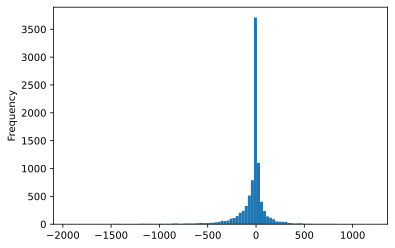

---------------------------------------------------------------------------


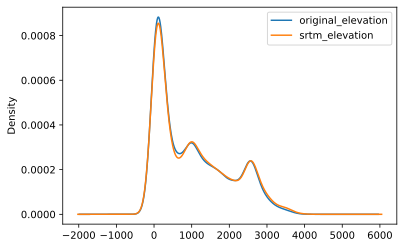

CPU times: user 1.43 s, sys: 28.4 ms, total: 1.45 s
Wall time: 1.5 s


In [ ]:
#@title Colombia Elevation Differences
%%time

elevations = elevations.interpolate(method='nearest')
elevations = elevations.assign(
    diff=lambda x: x.original_elevation-x.srtm_elevation
    )
elevations.to_csv('colomb97_elevations.csv')

dMarkdown('**Null sum:**')
print(elevations.isnull().sum())

colomb97_elevations = pd.read_csv(
    'colomb97_elevations.csv',
    index_col=[0]
    )
display(colomb97_elevations)

colomb97_elevations['diff'].plot.hist(bins=100)
plt.yscale('linear')# 'log', 'linear'
plt.show()
print('---'*25)
colomb97_elevations[['original_elevation',
                     'srtm_elevation'
                     ]].plot.kde()
plt.show()